[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ThomasAlbin/Astroniz-YT-Tutorials/blob/main/[ML1]-Asteroid-Spectra/8_dl_dense_multiclass.ipynb)

# Step 8: Deep Learning - A Dense Network

Now it is time to start using [keras](https://www.tensorflow.org/api_docs/python/tf/keras) for our next step: applying neural network architectures on or spectra data.

In this session we will start eeeeeeasily by creating a simple "Dense-layer-based" neural network. Please note: we are not covering the theory of neural networks in detail. I think there are tons of amazing tutorials, animations and videos out there that would easily outperform my useless drawing skills. Here, we simply focus on space science data, namely asteroid spectra.

Anyway. The next session will cover convolutional networks, just for demonstration purposes and then we will cover something ... more interesting I think, where I will also focus on describing more complex architectures.

Happy coding!

In [1]:
# Import standard libraries
import os

# Import installed libraries
import numpy as np
import pandas as pd

import sklearn
from sklearn import preprocessing

In [2]:
# Let's mount the Google Drive, where we store files and models (if applicable, otherwise work
# locally)
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

In [3]:
# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [4]:
# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

In [5]:
# We need to encode our string-based labels to either a sparse representation (class C becomes 0,
# S becomes 1, etc.) or to One-Hot-Encoding (e.g., C becomes [1, 0, 0, 0], S becomes [0, 1, 0, 0]
# and so on.

# Please note: a better way to create models that can be used in production, encoding shall be
# stored e.g., in a json file. Otherwise one needs to store the encoding class (otherwise the
# encoding - decoding information is gone!!!)
label_encoder = preprocessing.OneHotEncoder(sparse=True)
asteroids_oh_y = label_encoder.fit_transform(asteroids_y.reshape(-1,1)).toarray()

In [6]:
# Let's take a look at a class
print(asteroids_oh_y[0])

[1. 0. 0. 0.]


In [7]:
# OK how are things encoded?
oh_init = [1, 0, 0, 0]
for n in range(4):
    oh_class = oh_init[-n:] + oh_init[:-n]
    org_class = label_encoder.inverse_transform([oh_class])
    print(f"One-Hot-Vector {oh_class} corresponds to the Main Group: {org_class[0][0]}")

One-Hot-Vector [1, 0, 0, 0] corresponds to the Main Group: C
One-Hot-Vector [0, 1, 0, 0] corresponds to the Main Group: Other
One-Hot-Vector [0, 0, 1, 0] corresponds to the Main Group: S
One-Hot-Vector [0, 0, 0, 1] corresponds to the Main Group: X


In [8]:
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_oh_y[train_index], asteroids_oh_y[test_index]

## Imbalanced Datasets

... are a pain to work with. But it doesn't need to be, if you are aware of some pitfalls and useful metrics. Tensorflow provides a nice blog post [here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

In [9]:
# We need to create weights for our samples. Similar like the class weights, but here, our classes
# are one-hot encoded. Sample weights are easier to handle!
from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight("balanced", y=y_train)

In [10]:
import tensorflow.keras as keras

# Get the number of inputs
n_inputs = asteroids_X.shape[1]

def create_model():

    # Normalizsation layer (like the scikit-learn StandardScaler)
    normalizer = keras.layers.Normalization(axis=1)
    normalizer.adapt(X_train)

    # Create now a simple Dense based network
    input_layer = keras.Input(shape=(n_inputs,))

    hidden_layer = normalizer(input_layer)
    
    hidden_layer = keras.layers.Dense(25)(hidden_layer)
    hidden_layer = keras.layers.ReLU()(hidden_layer)

    hidden_layer = keras.layers.Dense(10)(hidden_layer)
    hidden_layer = keras.layers.ReLU()(hidden_layer)

    output_layer = keras.layers.Dense(4, activation="softmax")(hidden_layer)

    # Create now the model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

model = create_model()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# Show the model summary
model.summary()

# The training won't take long. Let's exceed the number of epochs
end_epoch = 500
batch_size = 32

# And train! With a validation split of 25 % and the splitting prior we have:
# Training: 60 %
# Validation: 20 %
# Test: 20 %
history = model.fit(X_train, y_train,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0, 
                    validation_split=0.25,
                    sample_weight=sample_weight)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49)]              0         
                                                                 
 normalization (Normalizatio  (None, 49)               99        
 n)                                                              
                                                                 
 dense (Dense)               (None, 25)                1250      
                                                                 
 re_lu (ReLU)                (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                260       
                                                                 
 re_lu_1 (ReLU)              (None, 10)                0         
                                                             

2022-03-19 12:52:58.800566: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Please note, online tutorials show mostly "default" batch sizes, like 32, 64, etc. But take a
# look at the size of the last batch. It does not correspond to the batch size itself! Be aware of
# these things
print(f"'Last' batch size: {len(X_train) % batch_size}")

'Last' batch size: 15


Text(0, 0.5, 'Loss')

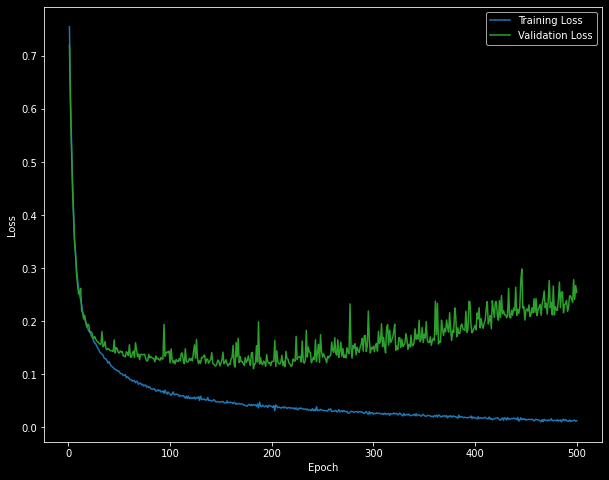

In [12]:
# Let's plot the losses
from matplotlib import pyplot as plt

plt.style.use("dark_background")

plt.figure(figsize=(10, 8))

plt.plot(np.arange(1,end_epoch+1,1),
         history.history["loss"], color="tab:blue", label="Training Loss")
plt.plot(np.arange(1,end_epoch+1,1),
         history.history["val_loss"], color="tab:green", label="Validation Loss")

plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")

In [13]:
# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = create_model()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# Show the model summary
model.summary()

# The training won't take long. Let's exceed the number of epochs
end_epoch = 500
batch_size = 32

history = model.fit(X_train, y_train,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0, 
                    validation_split=0.25,
                    sample_weight=sample_weight,
                    callbacks=[es_callback])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 49)]              0         
                                                                 
 normalization_1 (Normalizat  (None, 49)               99        
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 25)                1250      
                                                                 
 re_lu_2 (ReLU)              (None, 25)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                260       
                                                                 
 re_lu_3 (ReLU)              (None, 10)                0         
                                                           

In [14]:
# Compute class probabilities
y_test_prop_pred = model.predict(X_test)
print(y_test_prop_pred)

[[1.29795794e-07 1.03094885e-02 9.89566445e-01 1.23920254e-04]
 [6.06956547e-08 1.54630737e-02 9.84533668e-01 3.14087424e-06]
 [4.80215560e-04 6.52816539e-07 3.71580029e-07 9.99518871e-01]
 ...
 [9.99819338e-01 4.48895003e-17 1.00502703e-16 1.80703719e-04]
 [4.10871138e-07 1.12201907e-02 9.88674343e-01 1.05089777e-04]
 [1.89255559e-06 1.52781308e-02 9.84641254e-01 7.86826204e-05]]


In [15]:
# Compute the corresponding one-hot classes
y_test_oh_pred = np.zeros_like(y_test_prop_pred)
y_test_oh_pred[np.arange(len(y_test_prop_pred)), y_test_prop_pred.argmax(1)] = 1
print(y_test_oh_pred)

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [16]:
# Re-transform the classes now!
asteroid_classes_test = label_encoder.inverse_transform(y_test).reshape(1, -1)[0]
asteroid_classes_test_pred = label_encoder.inverse_transform(y_test_oh_pred).reshape(1, -1)[0]

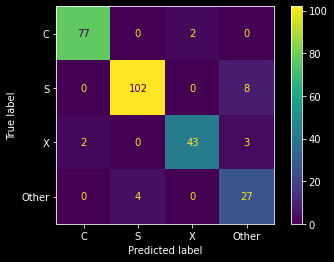

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Compute the confusion matrix
conf_mat = confusion_matrix(asteroid_classes_test,
                            asteroid_classes_test_pred,
                            labels=["C", "S", "X", "Other"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=["C", "S", "X", "Other"])
disp.plot()
plt.show()

In [18]:
# A combined score
f1_score = round(sklearn.metrics.f1_score(asteroid_classes_test, asteroid_classes_test_pred, average="weighted"), 3)
print(f"F1 Score: {f1_score}")

F1 Score: 0.931
